In [42]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__


**Requirements**



In [82]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [137]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>": 0,"<EOS>": 1}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
MAX_LENGTH = 10
SEED = 0

vocab_filter = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p, reverse = False):
    if reverse == True:
        return len(p[0].split(' ')) < MAX_LENGTH and \
                len(p[1].split(' ')) < MAX_LENGTH and \
                p[1].startswith(vocab_filter)
    else:
        return len(p[1].split(' ')) < MAX_LENGTH and \
                len(p[0].split(' ')) < MAX_LENGTH and \
                p[0].startswith(vocab_filter)


def filterPairs(pairs, reverse = False):
    return [pair for pair in pairs if filterPair(pair, reverse=reverse)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, reverse=reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    # Subtract 2 to remove SOS and EOS from count
    print(input_lang.name, input_lang.n_words-2)
    print(output_lang.name, output_lang.n_words-2)
    return input_lang, output_lang, pairs

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded 
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # (1,1) is for numlayers=1, batchsize=1, shifted to randn from zeros
        return torch.randn(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size #256
        self.output_size = output_size #n_words in output vocab
        self.dropout_p = dropout_p
        self.max_length = max_length #10

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        # shifted to randn vs zeros
        return torch.randn(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [156]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ') if word != '<EOS>']


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def tensorsForEpochs(pairs, epochs):
    random.seed(SEED)
    input_tensor = torch.zeros([epochs, MAX_LENGTH], dtype=torch.long, device=device)
    target_tensor = torch.zeros([epochs, MAX_LENGTH], dtype=torch.long, device=device)
    for epoch in range(epochs):
        tfp_in, tfp_tgt = tensorsFromPair(random.choice(pairs))
        input_tensor[epoch][0:len(tfp_in)] = tfp_in.flatten()
        target_tensor[epoch][0:len(tfp_tgt)] = tfp_tgt.flatten()
    return input_tensor, target_tensor

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [22]:
teacher_forcing_ratio = 0.2


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    #input_length = input_tensor.shape
    #target_length = target_tensor.shape

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei, token in enumerate(input_tensor):
        #print(token, token.dtype)
        encoder_output, encoder_hidden = encoder(token, encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    '''
    # See below for shortened version of this section for own understanding and better clarity
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            print(decoder_output.shape, target_tensor[di])
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            print(decoder_output.shape, target_tensor[di])
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    '''
    
    for di, token in enumerate(target_tensor):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # Recall that first input is always SOS, thus current token is always compared to pred
        
        # Criterion expects batch as first dim, so must unsqeeze token to mimic batch size of one
        loss += criterion(decoder_output, token.unsqueeze(0))

        if use_teacher_forcing:
            # Teacher forcing to feed current target token as next input
            decoder_input = token 
        else:
            # Without teacher forcing: use its own predictions as the next input
            # topk extracts top softmax result
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

        if decoder_input.item() == EOS_token:
            break
            
    
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / (di+1)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %. This is also a plotting helper to plot epochs vs loss. Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [23]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.switch_backend('agg')

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [24]:
def trainIters(pairs, encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    print('Building tensors...')
    #training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(epochs)]
    training_pairs = tensorsForEpochs(pairs, epochs)
    criterion = nn.NLLLoss()
    print('Training...')
    for epoch, training_pair in enumerate(zip(*training_pairs), 1): #range(1, epochs + 1):
        #training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / epochs),
                                         epoch, epoch / epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    return plot_losses

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [89]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly(pairs, encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateBatch(pairs, encoder, decoder):
    output_pairs = []
    for pair in pairs:
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        output_pairs.append((output_sentence, pair[0]))
    return output_pairs

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [38]:
input_lang, output_lang, pairs = prepareData('eng', 'ita', True)
print(random.choice(pairs))

Reading lines...
Read 331799 sentence pairs
Trimmed to 30715 sentence pairs
Counting words...
Counted words:
ita 5218
eng 3059
['sorride sempre .', 'she is always smiling .']


In [39]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainIters(pairs, encoder1, attn_decoder1, 75000, print_every=5000)

Building tensors...
Training...
1m 24s (- 19m 45s) (5000 6%) 3.2583
2m 43s (- 17m 41s) (10000 13%) 2.5710
4m 1s (- 16m 7s) (15000 20%) 2.2534
5m 20s (- 14m 40s) (20000 26%) 1.9990
6m 38s (- 13m 16s) (25000 33%) 1.7843
7m 56s (- 11m 54s) (30000 40%) 1.6419
9m 15s (- 10m 34s) (35000 46%) 1.4872
10m 33s (- 9m 14s) (40000 53%) 1.4022
11m 50s (- 7m 53s) (45000 60%) 1.2968
13m 9s (- 6m 34s) (50000 66%) 1.1569
14m 27s (- 5m 15s) (55000 73%) 1.1244
15m 46s (- 3m 56s) (60000 80%) 1.0411
17m 4s (- 2m 37s) (65000 86%) 0.9701
18m 22s (- 1m 18s) (70000 93%) 0.9298
19m 39s (- 0m 0s) (75000 100%) 0.8746


<Figure size 432x288 with 0 Axes>

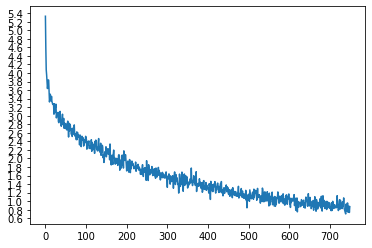

In [43]:
showPlot(plot_losses)

In [44]:
import pickle

model_path = '/home/team3/IDS576/models'

pickle.dump(encoder1, open(model_path+'/eng-ita_encoder1.pkl', 'wb'))
pickle.dump(attn_decoder1, open(model_path+'/eng-ita_attn_decoder1.pkl', 'wb'))

In [45]:
import pickle
model_path = '/home/team3/IDS576/models'
encoder1 = pickle.load(open(model_path+'/eng-ita_encoder1.pkl', 'rb'))
attn_decoder1 = pickle.load(open(model_path+'/eng-ita_attn_decoder1.pkl', 'rb'))

In [46]:
evaluateRandomly(pairs, encoder1, attn_decoder1)

> lui e una sorta di celebrita .
= he is something of a celebrity .
< he is a big of the city . <EOS>

> e un uomo sposato .
= he s a married man .
< he s a man of his man . <EOS>

> sto leggendo un libro adesso .
= i am reading a book now .
< i m reading a book now . <EOS>

> io non sono piu occupato .
= i m not busy anymore .
< i m not longer busy . <EOS>

> io sono un vero uomo .
= i m a real man .
< i m a real man . <EOS>

> io sono una persona responsabile .
= i m a responsible person .
< i m a responsible person person . <EOS>

> sono piu intelligente di voi .
= i m smarter than you .
< i m quicker than than you are <EOS>

> sei cosi immaturo .
= you re so immature .
< you re so busy with . . <EOS>

> sei un ragazzaccio vero ?
= you re a bad boy aren t you ?
< you re a doctor a man ! <EOS>

> e la proprietaria .
= you re the owner .
< you re the owner with me . <EOS>



/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




['i', 'm', 'going', 'to', 'the', 'park', '.', '<EOS>']


/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

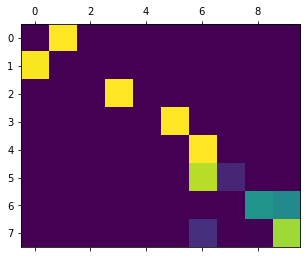

In [106]:
sentence = 'sto andando al parco .'
output_words, attentions = evaluate(encoder1, attn_decoder1, sentence)
plt.matshow(attentions.numpy())
print(output_words)

For a better viewing experience we will do the extra work of adding axes
and labels:




input = sto mangiando una mela .
output = i m eating an apple . . <EOS>


/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

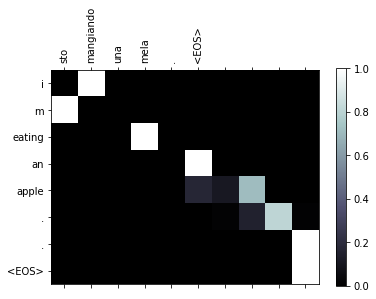

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

input = siamo stati i migliori amici dalla scuola .
output = we re the best way here school very serious .


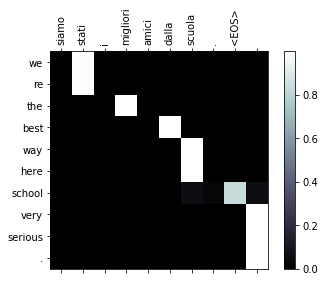

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

input = stiamo andando troppo in fretta .
output = we re working in the too too . . <EOS>


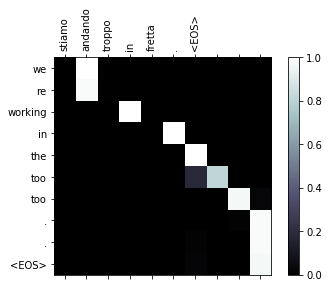

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

input = sei il migliore in tutto cio che fai
output = you re the only what i know . <EOS>


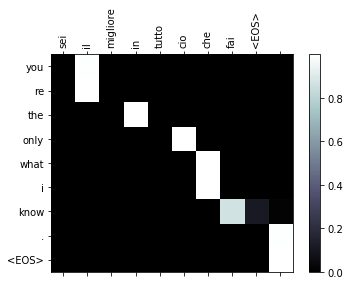

In [108]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("sto mangiando una mela .")

evaluateAndShowAttention("siamo stati i migliori amici dalla scuola .")

evaluateAndShowAttention("stiamo andando troppo in fretta .")

evaluateAndShowAttention("sei il migliore in tutto cio che fai")

#### 2.2. Now train another model (Model 2) for the reverse (i.e., from English to the language you chose). In this model, use the GloVe 100 dimensional embeddings (see notebook 4, cell 2 for an example) while training.

The following GloVe loading and use code were adapted from this post https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

In [23]:
# Only run once - run next cell to reload pickled files
import bcolz

glove_path = '/home/team3/IDS576/glove'
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.100.dat', mode='w')

with open(f'{glove_path}/glove.6B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 100)), rootdir=f'{glove_path}/6B.100.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.100_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.100_idx.pkl', 'wb'))

In [61]:
# Run this to load glove data
import bcolz
glove_path = '/home/team3/IDS576/glove'
vectors = bcolz.open(f'{glove_path}/6B.100.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.100_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.100_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [138]:
# import our sentences pairs and associated vocabs
MAX_LENGTH = 10

vocab_filter = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

input_lang, output_lang, pairs = prepareData('eng', 'ita', False)
print(random.choice(pairs))

Reading lines...
Read 331799 sentence pairs
Trimmed to 30715 sentence pairs
Counting words...
Counted words:
eng 3059
ita 5218
['we re going to fix that .', 'lo fisseremo .']


In [139]:
# Build vocab and check it against glove
cnt = 0
target_vocab = input_lang.word2index
for word in target_vocab:
    try:
        glove[word]
    except:
        print(f'The word "{word}" is not in GloVe.')
        cnt += 1
if cnt > 0:
    print(f'{cnt} words are not in GloVe.')
else:
    print('All of our words are in GloVe')

The word "<SOS>" is not in GloVe.
The word "<EOS>" is not in GloVe.
2 words are not in GloVe.


In [64]:
# Set weight matrix size as vocab + 2 to account for the SOS and EOS chars in our vocab
matrix_len = len(target_vocab) + 2
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

# Start fill of weight matrix at 2 to account for the SOS and EOS chars in our vocab at indices 0 and 1
for i, word in enumerate(target_vocab, 2):
    try:
        #print(i, word)
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
weights_matrix = torch.from_numpy(weights_matrix).to(device)
print(f'Words Found: {words_found} out of {len(target_vocab)}')
print(weights_matrix.shape, weights_matrix.dtype, weights_matrix.is_cuda)

Words Found: 3059 out of 3059
torch.Size([3061, 100]) torch.float64 True


In [65]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape  # vocab size x 100
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class GloveEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_size=1):
        super(GloveEncoderRNN, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers)

    def forward(self, inp, hidden):
        embedded = self.embedding(inp).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, device=device)

In [66]:
# Note that hidden size defines the GRU size, not the number of embeddings in this model
# Instead we use GloVe embed size of 100 as determined in the GloVe loading process
hidden_size = 256
encoder2 = GloveEncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainIters(pairs, encoder2, attn_decoder2, 75000, print_every=5000)

Building tensors...
Training...
1m 18s (- 18m 25s) (5000 6%) 4.4196
2m 34s (- 16m 44s) (10000 13%) 3.7891
3m 51s (- 15m 24s) (15000 20%) 3.5146
5m 7s (- 14m 6s) (20000 26%) 3.2964
6m 23s (- 12m 47s) (25000 33%) 3.1354
7m 39s (- 11m 28s) (30000 40%) 2.9808
8m 54s (- 10m 11s) (35000 46%) 2.8856
10m 10s (- 8m 54s) (40000 53%) 2.7594
11m 25s (- 7m 37s) (45000 60%) 2.6563
12m 40s (- 6m 20s) (50000 66%) 2.5329
13m 55s (- 5m 3s) (55000 73%) 2.4731
15m 10s (- 3m 47s) (60000 80%) 2.3648
16m 25s (- 2m 31s) (65000 86%) 2.2934
17m 39s (- 1m 15s) (70000 93%) 2.2128
18m 54s (- 0m 0s) (75000 100%) 2.1456


<Figure size 432x288 with 0 Axes>

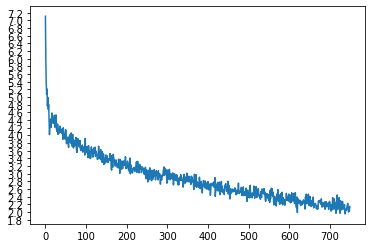

In [67]:
showPlot(plot_losses)

In [68]:
model_path = '/home/team3/IDS576/models'

pickle.dump(encoder2, open(model_path+'/eng-ita_encoder2.pkl', 'wb'))
pickle.dump(attn_decoder2, open(model_path+'/eng-ita_attn_decoder2.pkl', 'wb'))

In [69]:
import pickle
model_path = '/home/team3/IDS576/models'
encoder2 = pickle.load(open(model_path+'/eng-ita_encoder2.pkl', 'rb'))
attn_decoder2 = pickle.load(open(model_path+'/eng-ita_attn_decoder2.pkl', 'rb'))

In [84]:
evaluateRandomly(pairs, encoder2, attn_decoder2)

> i am in the house .
= io sono in casa .
< io sono in casa . . . SOS SOS SOS

> i m going to save more money .
= io risparmiero piu soldi .
< io bisogno bisogno di di . . . SOS <EOS>

> you re always singing .
= lei sta sempre cantando .
< voi sempre sempre in in in . SOS SOS SOS

> she s smart and beautiful .
= lei e bella e intelligente .
< e molto molto bella bella . . . SOS SOS

> i m afraid that s not acceptable .
= io temo che non sia accettabile .
< temo che non non sia . . . SOS SOS

> i m sure tom will be late .
= sono sicuro che tom sara in ritardo .
< sono sicura che tom tom in ritardo . . SOS

> i m a careful man .
= sono un uomo prudente .
< sono un un uomo per per . . . SOS

> she is in her hotel now .
= e nel suo hotel ora .
< e e suo suo suo . . . SOS <EOS>

> you re unambitious .
= tu sei priva di ambizioni .
< e e in in . . . SOS SOS SOS

> we re surprised .
= noi siamo sorprese .
< siamo siamo convinti avere questo . . . SOS SOS



/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

In [91]:
eval_pairs = [
    ['i am always grateful for your help .', 'sono sempre grato per il tuo aiuto .'],
    ['he s a good student .','e un bravo studente .'],
    ['she is very bad at horse riding .','lei e molto cattiva a cavallo .'],
    ['we love working on homework together !','ci piace lavorare insieme sui compiti !'],
    ['they are not going to leave tomorrow .','non partiranno domani .']
]

In [140]:
output_pairs = evaluateBatch(eval_pairs, encoder2, attn_decoder2)
output_pairs

> i am always grateful for your help .
= sono sempre grato per il tuo aiuto .
< io sono sempre per il il aiuto . . <EOS>

> he s a good student .
= e un bravo studente .
< e un grande grande per il il . . <EOS>

> she is very bad at horse riding .
= lei e molto cattiva a cavallo .
< e molto molto per per guidare . . . <EOS>

> we love working on homework together !
= ci piace lavorare insieme sui compiti !
< e sta per per il il aiuto . <EOS>

> they are not going to leave tomorrow .
= non partiranno domani .
< non non andare andare domani . <EOS>



/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

[('io sono sempre per il il aiuto . . <EOS>',
  'i am always grateful for your help .'),
 ('e un grande grande per il il . . <EOS>', 'he s a good student .'),
 ('e molto molto per per guidare . . . <EOS>',
  'she is very bad at horse riding .'),
 ('e sta per per il il aiuto . <EOS>',
  'we love working on homework together !'),
 ('non non andare andare domani . <EOS>',
  'they are not going to leave tomorrow .')]

In [141]:
# Swap language definitions
input_lang, output_lang = output_lang, input_lang
print(f'Input language is now: {input_lang.name}')
print(f'Output language is now: {output_lang.name}')

Input language is now: ita
Output language is now: eng


In [157]:
double_output_pairs = evaluateBatch(output_pairs, encoder1, attn_decoder1)

> io sono sempre per il il aiuto . . <EOS>
= i am always grateful for your help .
< i m very grateful for the . . <EOS>

> e un grande grande per il il . . <EOS>
= he s a good student .
< he re a big for the the . <EOS>

> e molto molto per per guidare . . . <EOS>
= she is very bad at horse riding .
< he is very very to drive . <EOS>

> e sta per per il il aiuto . <EOS>
= we love working on homework together !
< you re apt for the help . . <EOS>

> non non andare andare domani . <EOS>
= they are not going to leave tomorrow .
< we re not going to tomorrow tomorrow . . <EOS>



/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor